In [6]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

def readLastMassFraction(temperature, speciesName):
    try:
        fileName = os.path.expanduser(f'./data/1d_PS_{temperature}K_mass.csv')
        data = pd.read_csv(fileName)

        # speciesName이 포함된 컬럼을 자동 탐색
        matching_cols = [col for col in data.columns if speciesName in col]
        if not matching_cols:
            return None

        columnName = matching_cols[0]  # 예: 'Mass_fraction_C6H5C2H5_Soln#2 ()'
        return float(data[columnName].iloc[-1])
    except (FileNotFoundError, KeyError, IndexError, ValueError):
        return None

# Define temperatures and species
temperatures = np.array([1773, 2273, 2773])
chemkin_base_species = ['Mass_fraction_C6H5C2H3', 'Mass_fraction_C6H5C2H5', 'Mass_fraction_C7H8', 'Mass_fraction_CH4',
                        'Mass_fraction_C2H2', 'Mass_fraction_C2H4', 'Mass_fraction_C3H6', 'Mass_fraction_C6H6', 
                        'Mass_fraction_BIN1B', 'Mass_fraction_BIN1A']
chemkin_colors = ['red', 'red', 'red', 'black', 'green', 'blue', 'cyan', 'violet', 'gray', 'gold']
chemkin_labels = ['Styrene', 'Ethlybenzene', 'Toluene', '$\\rm{CH}_4$', 
                  '$\\rm{C}_2\\rm{H}_2$', '$\\rm{C}_2\\rm{H}_4$', '$\\rm{C}_3\\rm{H}_6$', '$\\rm{C}_6\\rm{H}_6$', 
                  '$\\rm{C}_{20}\\rm{H}_{10}$', '$\\rm{C}_{20}\\rm{H}_{16}$']



<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

C:\Users\super\AppData\Local\Temp\ipykernel_23500\1765147695.py:242: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = mpl.cm.get_cmap(AUTO_CMAP, max(len(product_cols_disp), 1))


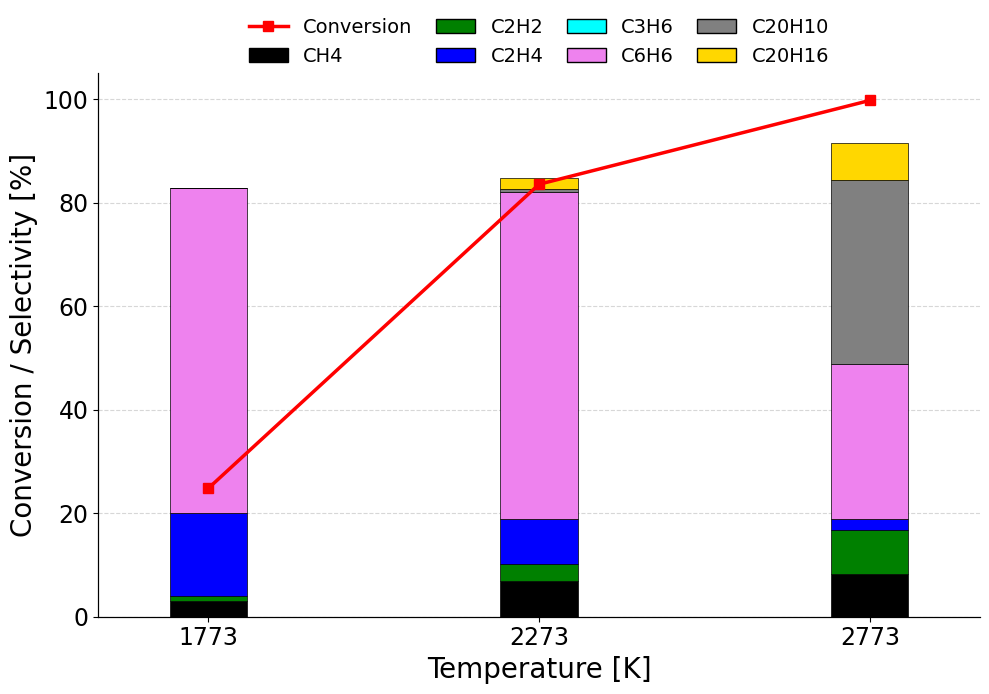

[OK] saved → ./out/selectivity_conversion_simple.csv
[OK] saved → ./fig/selectivity_conversion_simple.pdf


In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
import os
import re
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from typing import List, Dict, Optional, Tuple

# ========= 사용자 설정 =========
TEMPS = [1773, 2273, 2773]
TEMPLATE = "./data/1d_PS_{T}K_mass.csv"   # 파일 패턴
MDOT_COL_EXACT = "Exit_mass_flow_rate_PFRC2 (g/sec)"  # mDot 컬럼명 (g/s)
MF_SCALE = 1.0   # mass fraction이 %면 100.0, 0~1이면 1.0
LAST_N_AVG = 1   # 마지막 N개 평균(진동 줄이고 싶으면 3 등으로)
COL_SUFFIX = "_PFRC2 ()"  # species 컬럼 공통 접미사

# Reactants (분모용)
REACTANTS = [
    "Mass_fraction_C6H5C2H3",  # Styrene (C8H8)
    "Mass_fraction_C7H8",      # Toluene (C7H8)
    "Mass_fraction_C6H5C2H5",  # Ethylbenzene (C8H10)
]

# Products (셀렉티비티 계산 대상)
PRODUCTS = [
    "Mass_fraction_CH4",   # C1H4
    "Mass_fraction_C2H2",  # C2H2
    "Mass_fraction_C2H4",  # C2H4
    "Mass_fraction_C3H6",  # C3H6
    "Mass_fraction_C6H6",  # C6H6
    "Mass_fraction_BIN1B", # C20H10
    "Mass_fraction_BIN1A", # C20H16
]

# 보기 좋은 이름(범례/CSV 헤더)
DISPLAY = {
    "Mass_fraction_CH4": "CH4",
    "Mass_fraction_C2H2": "C2H2",
    "Mass_fraction_C2H4": "C2H4",
    "Mass_fraction_C3H6": "C3H6",
    "Mass_fraction_C6H6": "C6H6",
    "Mass_fraction_BIN1B": "C20H10",
    "Mass_fraction_BIN1A": "C20H16",
}

# ========= 화학식/분자량 유틸 =========
ATOMIC = {"C": 12.011, "H": 1.00784}
FORM_RE = re.compile(r"^C(\d+)H(\d+)$")

SPECIES_FORMULA = {
    "Mass_fraction_C6H5C2H3": "C8H8",
    "Mass_fraction_C7H8":     "C7H8",
    "Mass_fraction_C6H5C2H5": "C8H10",
    "Mass_fraction_CH4":      "C1H4",
    "Mass_fraction_C2H2":     "C2H2",
    "Mass_fraction_C2H4":     "C2H4",
    "Mass_fraction_C3H6":     "C3H6",
    "Mass_fraction_C6H6":     "C6H6",
    "Mass_fraction_BIN1B":    "C20H10",
    "Mass_fraction_BIN1A":    "C20H16",
}

def parse_formula(formula: str) -> Tuple[int, int]:
    m = FORM_RE.match(formula)
    if not m:
        raise ValueError(f"Formula parse error: {formula}")
    return int(m.group(1)), int(m.group(2))

def molar_mass(formula: str) -> float:
    nC, nH = parse_formula(formula)
    return nC * ATOMIC["C"] + nH * ATOMIC["H"]

# ========= I/O & 매칭/읽기 =========
def pick_column(df: pd.DataFrame, key: str) -> Optional[str]:
    """key: 'Mass_fraction_BIN1B' → 파일: 'Mass_fraction_BIN1B_PFRC2 ()'"""
    full = key + COL_SUFFIX if not key.endswith(COL_SUFFIX) else key
    exact = [c for c in df.columns if c.strip() == full]
    if exact:
        return exact[0]
    cands = [c for c in df.columns if full in c]
    if cands:
        return cands[0]
    # 과거 파일 호환
    exact_base = [c for c in df.columns if c.strip() == key]
    if exact_base:
        return exact_base[0]
    cands_base = [c for c in df.columns if key in c]
    return cands_base[0] if cands_base else None

def read_first_last(df: pd.DataFrame, col: str) -> Tuple[float, float]:
    s = pd.to_numeric(df[col], errors="coerce").dropna()
    if s.empty:
        return 0.0, 0.0
    first = float(s.iloc[0]) / MF_SCALE
    last  = float(s.iloc[-LAST_N_AVG:].mean()) / MF_SCALE if LAST_N_AVG > 1 else float(s.iloc[-1]) / MF_SCALE
    if first < 0 and abs(first) < 1e-12: first = 0.0
    if last  < 0 and abs(last) < 1e-12: last  = 0.0
    return first, last

def read_last(df: pd.DataFrame, col: str) -> float:
    s = pd.to_numeric(df[col], errors="coerce").dropna()
    if s.empty:
        return 0.0
    v = float(s.iloc[-LAST_N_AVG:].mean()) / MF_SCALE if LAST_N_AVG > 1 else float(s.iloc[-1]) / MF_SCALE
    return 0.0 if (v < 0 and abs(v) < 1e-12) else v

def get_mdot_kg_per_s(df: pd.DataFrame) -> Optional[float]:
    # g/s → kg/s
    col = pick_column(df, MDOT_COL_EXACT) or \
          next((c for c in df.columns if "Exit_mass_flow_rate_PFRC2" in c and "g/sec" in c), None)
    if not col:
        return None
    g_per_s = read_last(df, col)  # mDot 컬럼은 g/s 그대로
    return g_per_s / 1000.0

# ========= 핵심 계산 =========
def compute_for_file(csv_path: str,
                     reactants: List[str],
                     products: List[str]) -> Optional[Dict[str, float]]:
    if not os.path.exists(csv_path):
        print(f"[WARN] file not found: {csv_path}")
        return None
    df = pd.read_csv(csv_path)

    # mDot
    mDot = get_mdot_kg_per_s(df)
    if mDot is None:
        print(f"[WARN] mDot column not found in {csv_path}")
        return None

    # 분모(탄소 기준) + Conversion 위한 합계
    denom_carbon = 0.0
    sum_init_mf = 0.0
    sum_cons_mf = 0.0

    for rk in reactants:
        col = pick_column(df, rk)
        if not col:
            print(f"[WARN] reactant not found: {rk} in {csv_path}")
            continue
        f0, f1 = read_first_last(df, col)
        dm = f0 - f1
        if dm < 0:  # 데이터 잡음 방지
            dm = 0.0
        sum_init_mf += f0
        sum_cons_mf += dm
        formula = SPECIES_FORMULA[rk]
        nC, _ = parse_formula(formula)
        M = molar_mass(formula)
        denom_carbon += nC * mDot * (dm / M)

    if denom_carbon <= 0:
        print(f"[WARN] non-positive carbon basis in {csv_path}")
        return None

    # 생성물 셀렉티비티
    sel: Dict[str, float] = {}
    for pk in products:
        col = pick_column(df, pk)
        if not col:
            sel[pk] = 0.0   # 없으면 0%로 고정(열 보장)
            continue
        mf_last = read_last(df, col)
        formula = SPECIES_FORMULA[pk]
        nC, _ = parse_formula(formula)
        M = molar_mass(formula)
        carbon_flow = nC * mDot * (mf_last / M)
        sel[pk] = 100.0 * carbon_flow / denom_carbon

    # Conversion(%) = (총 소모 질량분율 / 총 초기 질량분율)×100
    conversion = (sum_cons_mf / sum_init_mf) * 100.0 if sum_init_mf > 0 else 0.0

    sel["_Conversion_%"] = conversion
    sel["_Total_Selectivity_%"] = sum(sel.values())
    sel["_mDot_kg_s"] = mDot
    return sel

# ========= 실행: 계산 =========
rows = []
for T in TEMPS:
    path = TEMPLATE.format(T=T)
    res = compute_for_file(path, REACTANTS, PRODUCTS)
    if not res:
        continue
    res["Temperature[K]"] = T
    rows.append(res)

if not rows:
    print("[ERR] No results.")
    raise SystemExit(0)

df = pd.DataFrame(rows).set_index("Temperature[K]").sort_index()
rename = {k: DISPLAY.get(k, k) for k in df.columns}
disp = df.rename(columns=rename)

# ========= 플롯 설정 =========
FIGSIZE = (10, 8)
STACK_WIDTH = 0.07

# ── 커스텀 막대 위치(좌표 직접 지정) ──
USE_CUSTOM_X = True
CUSTOM_X = [0.00, 0.3, 0.6]  # ← TEMPS 순서대로 막대 중심 x좌표
CUSTOM_TICKLABELS = [str(t) for t in TEMPS]

# 자동 간격(커스텀 안 쓸 때만 사용)
GAP = 0.0  # x = arange(n) * (1+GAP)

LABEL_SIZE = 20
TICK_SIZE  = 17
GRID_STYLE = {"linestyle": "--", "alpha": 0.5}

# 레전드(바깥 위 중앙, 행 수 지정)
LEGEND_LOC   = "lower center"
LEGEND_BBOX  = (0.5, 1.0)
LEGEND_SIZE  = 14
LEGEND_NROW  = 2

CONV_LINE_KW = {"linestyle": "-", "linewidth": 2.5, "marker": "s", "markersize": 7, "zorder": 5, "color": "red"}
SEL_YLIM  = (0, 105)
CONV_YLIM = (0, 105)

BAR_COLORS = {
    "CH4":    "black",
    "C2H2":   "green",
    "C2H4":   "blue",
    "C3H6":   "cyan",
    "C6H6":   "violet",
    "C20H10": "gray",
    "C20H16": "gold",
}
AUTO_CMAP = "tab20"

# ========= 플롯 =========
temps = disp.index.values
product_cols_disp = [DISPLAY.get(k, k) for k in PRODUCTS if k in df.columns]
disp[product_cols_disp] = disp[product_cols_disp].apply(pd.to_numeric, errors="coerce").fillna(0.0)
conv = pd.to_numeric(disp["_Conversion_%"], errors="coerce").fillna(0.0).values

import itertools, matplotlib as mpl
cmap = mpl.cm.get_cmap(AUTO_CMAP, max(len(product_cols_disp), 1))
auto_colors = itertools.cycle([mpl.colors.to_hex(cmap(i)) for i in range(cmap.N)])

# x 좌표
if USE_CUSTOM_X:
    if len(CUSTOM_X) != len(temps):
        raise ValueError(f"CUSTOM_X 길이({len(CUSTOM_X)})가 temps 길이({len(temps)})와 다릅니다.")
    x = np.asarray(CUSTOM_X, dtype=float)
    ticklabels = CUSTOM_TICKLABELS
else:
    x = np.arange(len(temps)) * (1.0 + GAP)
    ticklabels = [str(t) for t in temps]

plt.figure(figsize=FIGSIZE)
bottoms = np.zeros(len(temps))
legend_bar_handles = []

# 스택 막대(제품)
for col in product_cols_disp:
    y = disp[col].values
    color = BAR_COLORS.get(col, next(auto_colors))
    plt.bar(x, y, bottom=bottoms, width=STACK_WIDTH,
            label=col, color=color, zorder=2, edgecolor="black", linewidth=0.5)
    bottoms += y
    legend_bar_handles.append(mpl.patches.Patch(facecolor=color, edgecolor="black", label=col))

ax = plt.gca()
ax.set_axisbelow(True)
ax.grid(True, axis="y", **GRID_STYLE)
ax.set_xlabel("Temperature [K]", fontsize=LABEL_SIZE)
ax.set_ylabel("Conversion / Selectivity [%]", fontsize=LABEL_SIZE)
ax.set_xticks(x, ticklabels, fontsize=TICK_SIZE)
ax.tick_params(axis="y", labelsize=TICK_SIZE)
ax.margins(x=0.02)
if SEL_YLIM: ax.set_ylim(*SEL_YLIM)

# ✅ 우측/윗쪽 스파인 숨기기
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)

# x축 패딩(막대가 잘리지 않게)
pad = max(STACK_WIDTH, 0.1)
ax.set_xlim(x.min() - pad, x.max() + pad)

# Conversion 보조축 (틱/라벨 숨김)
ax2 = ax.twinx()
(line,) = ax2.plot(x, conv, label="Conversion", **CONV_LINE_KW)
ax2.tick_params(right=False, labelright=False)
ax2.set_yticks([])
ax2.grid(False)
if CONV_YLIM: ax2.set_ylim(*CONV_YLIM)

# ✅ 보조축도 우측/윗쪽 스파인 숨기기
ax2.spines["right"].set_visible(False)
ax2.spines["top"].set_visible(False)

# 레전드(행 수 지정 → 열 자동 계산)
legend_handles = [line] + legend_bar_handles
legend_labels  = ["Conversion"] + product_cols_disp
LEGEND_NCOL    = math.ceil(len(legend_handles) / LEGEND_NROW)

ax.legend(legend_handles, legend_labels,
          loc=LEGEND_LOC, bbox_to_anchor=LEGEND_BBOX,
          fontsize=LEGEND_SIZE, ncol=LEGEND_NCOL,
          frameon=False, borderaxespad=0.0, columnspacing=1.2, handlelength=2.0)

plt.tight_layout(rect=[0, 0, 1, 0.88])  # 상단 여백 확보
os.makedirs("./fig", exist_ok=True)
plt.savefig("./fig/1D_PS_selectivity_conversion_major.pdf", bbox_inches="tight", dpi=300)
plt.show()

# CSV 저장
os.makedirs("./out", exist_ok=True)
disp.to_csv("./out/1D_PS_selectivity_conversion_major.csv", float_format="%.6f")
print("[OK] saved → ./out/selectivity_conversion_simple.csv")
print("[OK] saved → ./fig/selectivity_conversion_simple.pdf")
